In [78]:
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pandas as pd
plt.rcParams['animation.ffmpeg_path'] = '/Users/michael/miniconda3/bin/ffmpeg'

In [5]:
mile_to_meter = 1609.34
meters_in_marathon = 42164.81
total_race_time = 2*3600+45*60+14

In [45]:
df = pd.read_csv('data.csv')
elevations = df['elevation'].to_numpy()
paces = df['pace'].to_numpy()
hrs = df['hr'].to_numpy()
positions = df[['lats', 'lons']].to_numpy()
times = np.arange(0,total_race_time)

In [44]:
stamen_terrain = cimgt.Stamen(style='terrain-background')

In [50]:
def pace_to_str(pace):
    return str(int(pace)) + ":" + str(int((pace % 1)*60)).zfill(2)

In [121]:
#display and playback
%matplotlib notebook
sns.set_style("white")

secs_per_frame = 20
N_frames = int(total_race_time / secs_per_frame)

#generate labels
e_text = p_text = h_text = []
prev = 0
for i in range(1, N_frames):
    e_text = e_text + [str(int(np.mean(elevations[prev*secs_per_frame:i*secs_per_frame])))]
    p_text = p_text + [pace_to_str(np.mean(paces[prev*secs_per_frame:i*secs_per_frame]))]
    h_text = h_text + [str(int(np.mean(hrs[prev*secs_per_frame:i*secs_per_frame])))]
    prev = i

#create plots
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(4,2, width_ratios = [5,1], height_ratios = [3,1,1,1])
m = plt.subplot(gs[0,:], projection=stamen_terrain.crs)
e = plt.subplot(gs[1,0])
eta = plt.subplot(gs[1,1])
p = plt.subplot(gs[2,0])
pta = plt.subplot(gs[2,1])
h = plt.subplot(gs[3,0])
hta = plt.subplot(gs[3,1])

#generate graph extents
m_extent = [min(positions[:,0])-.05, max(positions[:,0])+.05, min(positions[:,1])-.05, max(positions[:,1])+.05]
e_extent = [0, total_race_time, 0, 1.1*max(elevations)]
p_extent = [0, total_race_time, 0, 1.1*max(paces)]
h_extent = [0, total_race_time, 0, 1.1*max(hrs)]

#draw map
gl = m.gridlines(draw_labels=False)
m.set_extent(m_extent)
m.add_image(stamen_terrain, 11)
course = m.plot(positions[:,0], positions[:,1], color='black', transform = ccrs.PlateCarree())
endpoints = m.scatter([positions[0,0], positions[-1,0]], [positions[0,1], positions[-1,1]], color='black', marker='o', transform = ccrs.PlateCarree())
start = m.scatter([positions[0,0]], [positions[0,1]], color='orange', marker='o', zorder = 10, transform = ccrs.PlateCarree())

#make gradients
ez = np.empty((100,1,4), dtype = float)
rgb = mcolors.colorConverter.to_rgb('green')
ez[:,:,:3] = rgb
ez[:,:,-1] = np.linspace(0, 1.0, 100)[:,None]

pz = np.empty((100,1,4), dtype = float)
rgb = mcolors.colorConverter.to_rgb('cyan')
pz[:,:,:3] = rgb
pz[:,:,-1] = np.linspace(0, 1.0, 100)[:,None]

hz = np.empty((100,1,4), dtype = float)
rgb = mcolors.colorConverter.to_rgb('red')
hz[:,:,:3] = rgb
hz[:,:,-1] = np.linspace(0, 1.0, 100)[:,None]

#create graph artists
ei = e.imshow(ez, aspect='auto', extent=e_extent,
             origin='lower', zorder = 10)
ei.set_visible(False)
pi = p.imshow(pz, aspect='auto', extent=p_extent,
             origin='lower', zorder = 10)
pi.set_visible(False)
hi = h.imshow(hz, aspect='auto', extent=h_extent,
             origin='lower', zorder = 10)
hi.set_visible(False)

# add map artists
prog, = m.plot([], [], color='orange', transform = ccrs.PlateCarree())
end, = m.plot(positions[-1,0], positions[-1,1], color='orange', marker='o', zorder = 100, transform = ccrs.PlateCarree())
end.set_visible(False)

# create label artists
big = {'weight': 'bold', 'size': 36}
et = eta.text(.5,.5, "", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=big)
pt = pta.text(.5,.5, "", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=big)
ht = hta.text(.5,.5, "", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=big)

# array of artists
artists = [ei, pi, hi, et, pt, ht, prog, end]

# format axes
little = {'size': 18}
ett = eta.text(.5,.3, "Feet", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=little)
ptt = pta.text(.5,.3, "Minute/Mile", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=little)
htt = hta.text(.5,.3, "BPM", 
        horizontalalignment='center',
        verticalalignment='center', fontdict=little)

title = {'size': 36}

for ax in [e, p, h]:
    ax.set_xlim(0, total_race_time)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
m.set_title("USTAF #WA15001LB, 07/28/19", fontdict=title)
e.set_ylim(e_extent[2], e_extent[3])
e.set_xticklabels([])
e.set_title('Elevation', fontdict=little)
p.set_ylim(p_extent[2], p_extent[3])
p.set_xticklabels([])
p.set_title('Pace', fontdict = little)
h.set_ylim(h_extent[2], h_extent[3])
h.set_title('Heart Rate', fontdict = little)
h.set_xlabel('Time (s)', fontdict = little)

for ax in [eta, pta, hta]:
    ax.set_xlim(0.,1.)
    ax.set_ylim(0.,1.)
    ax.axis('off')

# data and label arrays
dats = [elevations, paces, hrs, positions.T]
labels = [e_text, p_text, h_text]

x = y1 = y2 = y3 = y4 = []

# animation updates
def update_lines(num, artists, times, dats, labels):
    # current data
    xs = times[:num*secs_per_frame]
    y1 = dats[0][:num*secs_per_frame]
    y2 = dats[1][:num*secs_per_frame]
    y3 = dats[2][:num*secs_per_frame]
    y4 = dats[3][...,:num*secs_per_frame]
    
    # clip gradient artists to data
    xy1 = np.column_stack([xs, y1])
    xy1 = np.vstack([[0, e_extent[2]], xy1, [num*secs_per_frame, e_extent[2]], [0, e_extent[2]]])
    clip_path = Polygon(xy1, facecolor='none', edgecolor='none', closed=True)
    e.add_patch(clip_path)
    artists[0].set_visible(True)
    artists[0].set_clip_path(clip_path)
    
    xy2 = np.column_stack([xs, y2])
    xy2 = np.vstack([[0, p_extent[2]], xy2, [num*secs_per_frame, p_extent[2]], [0, p_extent[2]]])
    clip_path = Polygon(xy2, facecolor='none', edgecolor='none', closed=True)
    p.add_patch(clip_path)
    artists[1].set_visible(True)
    artists[1].set_clip_path(clip_path)
    
    xy3 = np.column_stack([xs, y3])
    xy3 = np.vstack([[0, h_extent[2]], xy3, [num*secs_per_frame, h_extent[2]], [0, h_extent[2]]])
    clip_path = Polygon(xy3, facecolor='none', edgecolor='none', closed=True)
    h.add_patch(clip_path)
    artists[2].set_visible(True)
    artists[2].set_clip_path(clip_path)
    
    # update labels
    artists[3].set_text(labels[0][num])
    artists[4].set_text(labels[1][num])
    artists[5].set_text(labels[2][num])
    artists[6].set_data(y4)
    
    # update finish
    artists[7].set_visible((num >= N_frames-3))

line_ani = FuncAnimation(fig, update_lines, N_frames, fargs=(artists, times, dats, labels),
                                   interval=10, blit=False)
# plt.show()
line_ani.save('race.mp4', fps=24, dpi = 150, extra_args=['-vcodec', 'mpeg4', '-b', '5000k'])

<IPython.core.display.Javascript object>

IndexError: list index out of range

In [113]:
int(total_race_time / secs_per_frame)

495

In [86]:
N_frames

495

In [89]:
[dats[3][0,-1]], [dats[3][1,-1]]

([-121.74467243283921], [47.47416158827358])

<IPython.core.display.Javascript object>


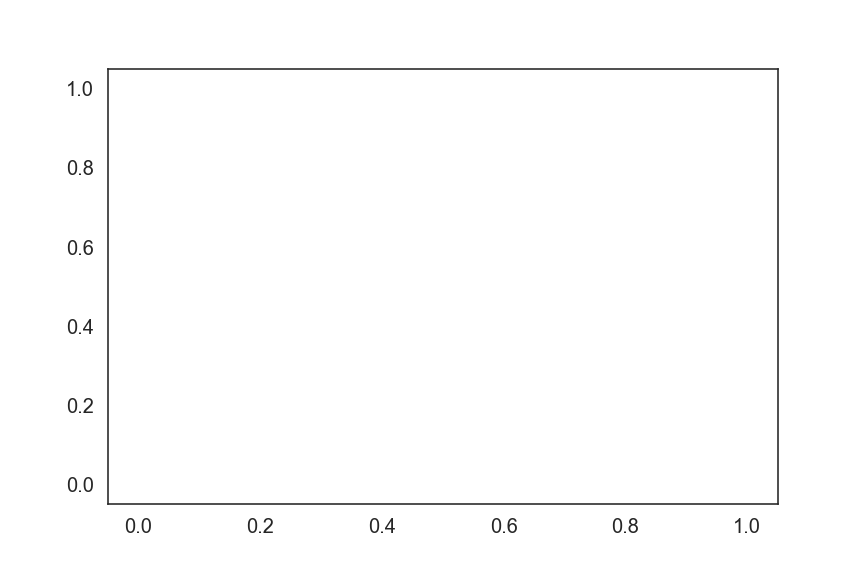

In [102]:
plt.plot([],[], color = 'orange', marker='o')
p